# Modeling DepMap data

In [1]:
import pandas as pd
import numpy as np
import plotnine as gg
import pymc3 as pm
import arviz as az
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
gg.theme_set(gg.theme_minimal(base_family="Arial"))

In [3]:
RANDOM_SEED = 103

## Model 1. Single gene linear model with one covariate

Model the logFC of one gene in multiple cell lines using a single predictor: RNA expression.

$$
logFC \sim Normal(\mu, \sigma) \\
\mu = \alpha + \beta R \\
\alpha \sim \mathcal{N}(0, 10) \\
\beta \sim \mathcal{N}(0, 1) \\
\sigma \sim \text{HalfNormal}(5)
$$

Simulated values:

- $\alpha$ = 0.5
- $\beta$ = -1
- $\sigma$ = 0.3

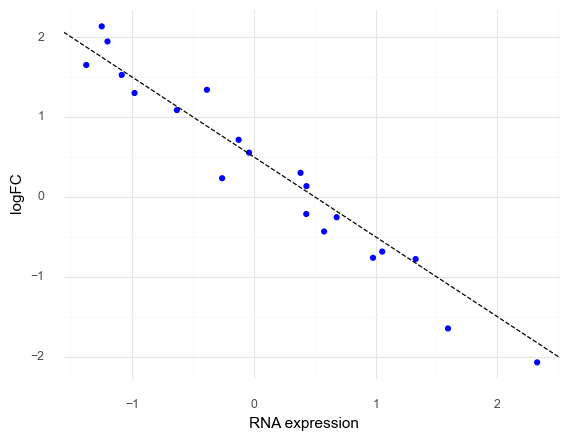

<ggplot: (8773775981597)>

In [4]:
N_CELL_LINES = 20
real_alpha = 0.5
real_beta = -1
real_sigma = 0.3

# Synthetic data
np.random.seed(RANDOM_SEED)
rna = np.random.randn(N_CELL_LINES)
logfc = real_alpha + real_beta * rna + np.random.normal(0, real_sigma, N_CELL_LINES)
data = pd.DataFrame({"rna": rna, "logfc": logfc})

(
    gg.ggplot(data, gg.aes("rna", "logfc"))
    + gg.geom_point(color="blue")
    + gg.geom_abline(slope=real_beta, intercept=real_alpha, linetype="--")
    + gg.labs(x="RNA expression", y="logFC")
)

In [5]:
with pm.Model() as model1:
    alpha = pm.Normal("alpha", 0, 10)
    beta = pm.Normal("beta", 0, 1)
    sigma = pm.HalfNormal("sigma", 5)

    mu = pm.Deterministic("mu", alpha + beta * data.rna)

    logfc = pm.Normal("logfc", mu=mu, sigma=sigma, observed=data.logfc)

    model1_prior_check = pm.sample_prior_predictive(random_seed=RANDOM_SEED)
    model1_trace = pm.sample(1000)
    model1_post_check = pm.sample_posterior_predictive(
        model1_trace, random_seed=RANDOM_SEED
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
100%|██████████| 2000/2000 [00:03<00:00, 572.72it/s]


In [6]:
az_model1 = az.from_pymc3(
    model1_trace, posterior_predictive=model1_post_check, prior=model1_prior_check
)

In [7]:
var_names = ["alpha", "beta", "sigma"]
az.summary(az_model1, var_names=var_names)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.439,0.067,0.304,0.552,0.002,0.001,1935.0,1923.0,1937.0,1369.0,1.0
beta,-1.105,0.062,-1.213,-0.980,0.001,0.001,1760.0,1760.0,1762.0,1376.0,1.0
sigma,0.277,0.052,0.190,0.376,0.001,0.001,1774.0,1709.0,1837.0,1317.0,1.0


/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.7/site-packages/arviz/plots/

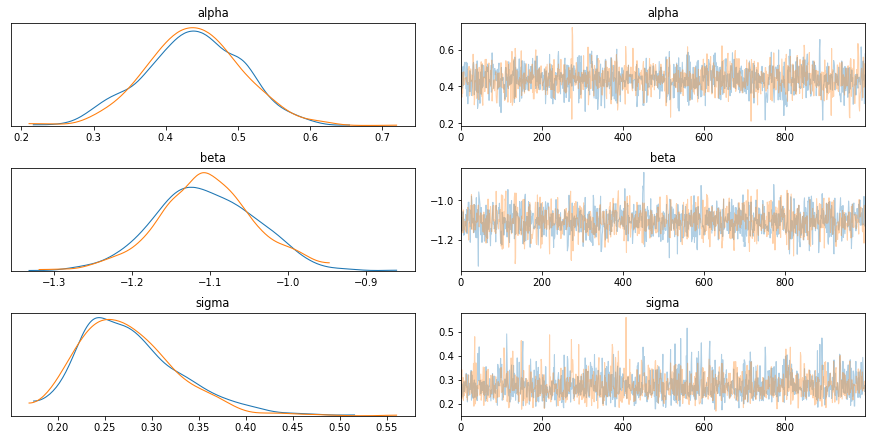

In [8]:
az.plot_trace(az_model1, var_names=var_names)
plt.show()

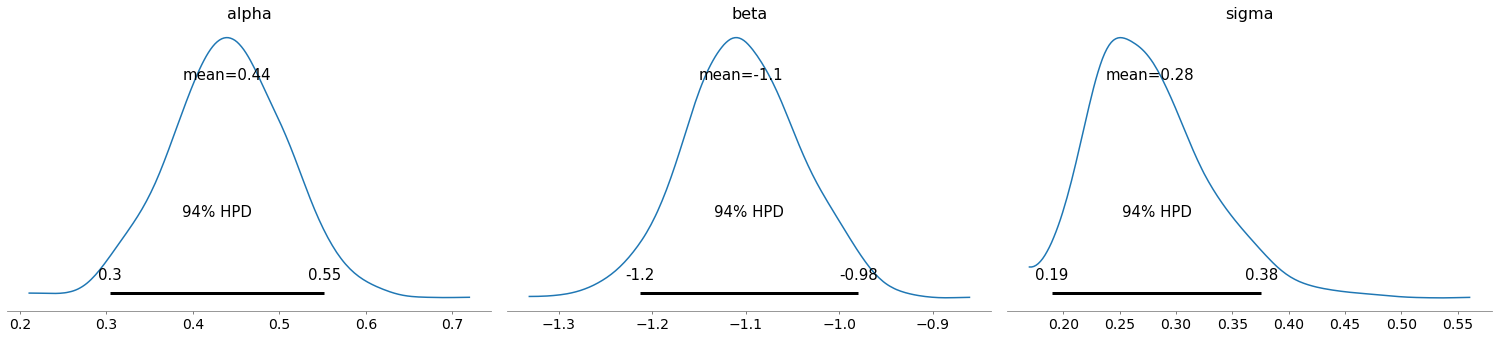

In [9]:
az.plot_posterior(az_model1, var_names=var_names)
plt.show()

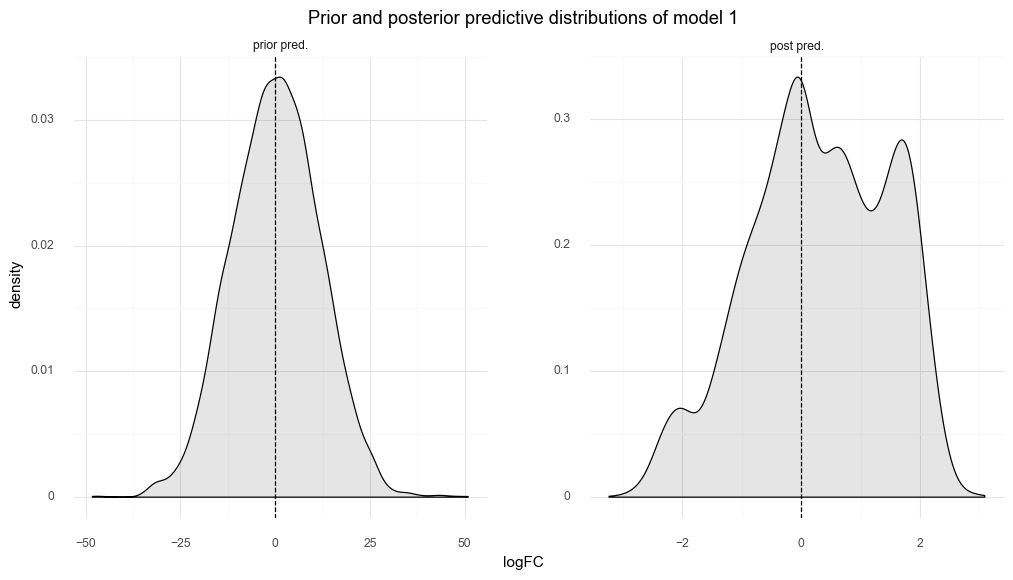

<ggplot: (8773776036105)>

In [10]:
prior_pred = (
    az_model1.prior_predictive.to_dataframe()
    .sample(frac=0.5)
    .assign(pred="prior pred.")
)
post_pred = (
    az_model1.posterior_predictive.to_dataframe()
    .sample(frac=0.2)
    .assign(pred="post pred.")
)
model1_preds = pd.concat([prior_pred, post_pred])
model1_preds["pred"] = pd.Categorical(
    model1_preds.pred, categories=["prior pred.", "post pred."]
)
(
    gg.ggplot(model1_preds, gg.aes("logfc"))
    + gg.facet_wrap("pred", nrow=1, scales="free")
    + gg.geom_density(fill="black", alpha=0.1)
    + gg.geom_vline(xintercept=0, linetype="--")
    + gg.scale_y_continuous(limits=(0, np.nan))
    + gg.labs(
        x="logFC",
        y="density",
        title="Prior and posterior predictive distributions of model 1",
    )
    + gg.theme(figure_size=[12, 6], subplots_adjust={"wspace": 0.25})
)

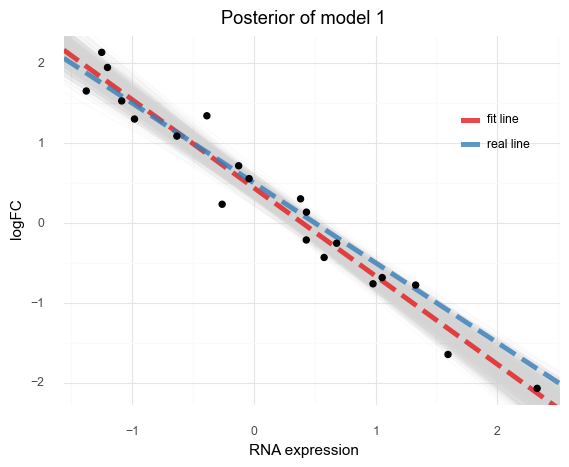

<ggplot: (8773775981601)>

In [11]:
post = az_model1.posterior.to_dataframe()

post_summary = pd.DataFrame(
    {
        "name": ["real line", "fit line"],
        "slope": [real_beta, post.mean()["beta"]],
        "intercept": [real_alpha, post.mean()["alpha"]],
    }
)

(
    gg.ggplot(post.sample(frac=0.1))
    + gg.geom_abline(
        gg.aes(slope="beta", intercept="alpha"), alpha=0.1, color="lightgrey"
    )
    + gg.geom_abline(
        gg.aes(slope="slope", intercept="intercept", color="name"),
        data=post_summary,
        size=2,
        alpha=0.8,
        linetype="--",
    )
    + gg.geom_point(gg.aes(x="rna", y="logfc"), data=data, color="black", size=2)
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.theme(legend_position=(0.8, 0.7))
    + gg.labs(x="RNA expression", y="logFC", title="Posterior of model 1", color="")
)

---

## Model 2. Multiple genes hierarchical model with one covariate